#Bài toán 2: dự đoán khả năng mở rộng bơ conventional tại California

In [1]:
#Note: đối với bài toán time series, dữ liệu phải liên tục
#---> không loại outlier. Không xóa dòng.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do'

/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do


###Chuẩn bị data

In [4]:
#lấy data từ đầu, không lấy data đã qua xử lý

In [5]:
%%capture
!pip install fbprophet
!pip install pandas-profiling==2.7.1
!pip install pmdarima
!pip install xgboost

In [6]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from pmdarima import auto_arima 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
data = pd.read_csv('avocado.csv', index_col = 0)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [9]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


#Áp dụng các thuật toán time series để dự đoán giá bơ conventional trong tương lại ở California

In [10]:
#sử dụng các thuật toán như ARIMA, Prophet, Holt-Winter

In [11]:
df = data[['Date', 'AveragePrice', 'type', 'region']]

In [12]:
#lọc lấy region = California và type =  conventional
df = df[df['region'] == 'California']
df = df[df['type'] == 'conventional']

In [13]:
df.head()

,Date,AveragePrice,type,region
0,2015-12-27,0.90,conventional,California
1,2015-12-20,0.94,conventional,California
2,2015-12-13,0.87,conventional,California
3,2015-12-06,0.78,conventional,California
4,2015-11-29,0.91,conventional,California


In [14]:
#chuyển cột Date sang dạng datetime
df['Date']= pd.to_datetime(df['Date'])

In [15]:
#MS: Month Start, tính mean của các tháng theo month
df1 = df.resample('MS', on='Date').mean()

In [16]:
df1.head()

,AveragePrice
Date,
2015-01-01,0.9825
2015-02-01,0.9200
2015-03-01,1.0040
2015-04-01,1.0950
2015-05-01,0.9940


In [17]:
df1 = df1.rename_axis('Month').reset_index()
df1.head()

,Month,AveragePrice
0,2015-01-01,0.9825
1,2015-02-01,0.9200
2,2015-03-01,1.0040
3,2015-04-01,1.0950
4,2015-05-01,0.9940


In [18]:
#đổi tên cá cột
df1.columns = ['ds','y']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      39 non-null     datetime64[ns]
 1   y       39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 752.0 bytes


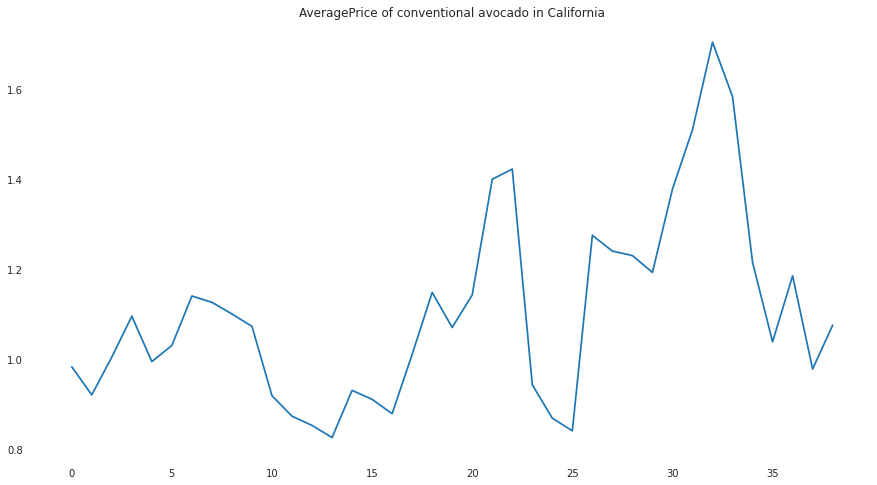

In [19]:
# Trực quan hóa giá trung bình qua các tháng
plt.figure(figsize=(15,8))
plt.plot(df1.y)
plt.title('AveragePrice of conventional avocado in California')
plt.show()

Nhận xét: giá trung bình có xu hướng tăng qua các thời kỳ

In [20]:
#chia dữ liệu train/ test

In [21]:
#có 39 tháng --> 30 tháng cho train, 9 tháng cho test

In [22]:
#39 tháng cho train
train = df1.iloc[0:30]
train.tail()

,ds,y
25,2017-02-01,0.8400
26,2017-03-01,1.2750
27,2017-04-01,1.2400
28,2017-05-01,1.2300
29,2017-06-01,1.1925


In [23]:
#9 tháng cho test
test = df1.iloc[30:]
test.tail()

,ds,y
34,2017-11-01,1.2150
35,2017-12-01,1.0380
36,2018-01-01,1.1850
37,2018-02-01,0.9775
38,2018-03-01,1.0750


In [24]:
test.head()

,ds,y
30,2017-07-01,1.378
31,2017-08-01,1.510
32,2017-09-01,1.705
33,2017-10-01,1.584
34,2017-11-01,1.215


###Bước 4&5: Modeling & Evaluation/ Analyze & Report

#Build model - Prophet

In [25]:
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(train) #fit train --> 30 tháng

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [26]:
#9 month in test and 12 month to preidct new value
#test bắt đầu từ 2017-07-01, kết thúc 2018-03-01
#predict thêm 1 năm ==> kết thúc 2019-03-01
#model sẽ predict thời gian từ 9 tháng của test cộng thêm 12 tháng mới
months = pd.date_range('2017-07-01','2019-03-01',freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [27]:
#use model to make forcast
forecast = model.predict(future) 

In [28]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2017-07-01,1.419701
1,2017-08-01,1.374578
2,2017-09-01,1.428692
3,2017-10-01,1.606773
4,2017-11-01,1.585929


In [29]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
16,2018-11-01,1.766875
17,2018-12-01,1.587323
18,2019-01-01,1.564364
19,2019-02-01,1.549206
20,2019-03-01,1.642235


#Evaluate

In [30]:
df1['y'].mean()

1.1050769230769228

In [31]:
test['y'].mean()

1.296388888888889

In [32]:
#tính toán MAE/RMSE giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred)

In [33]:
y_test = test['y'].values #giá trị thực (9 giá trị)
y_pred = forecast['yhat'].values[:9] #9 giá trị đầu tiên
mae_p = mean_absolute_error(y_test,y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.190


In [34]:
rmse_p = sqrt(mean_squared_error(y_test,y_pred))
print('RMSE: %.3f' %rmse_p)

RMSE: 0.229


Nhận xét:
- mean(test) ~ 1.29, mae ~ 0.19 --> mean(mae)/mean(test) ~ 14.7 %
- mean của toàn data (df1.y) ~ 1.105, mae ~ 0.19 --> mean(mae)/mean(toàn data) ~ 17 %
==> sai lệch nhỏ, có thể chấp nhận

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

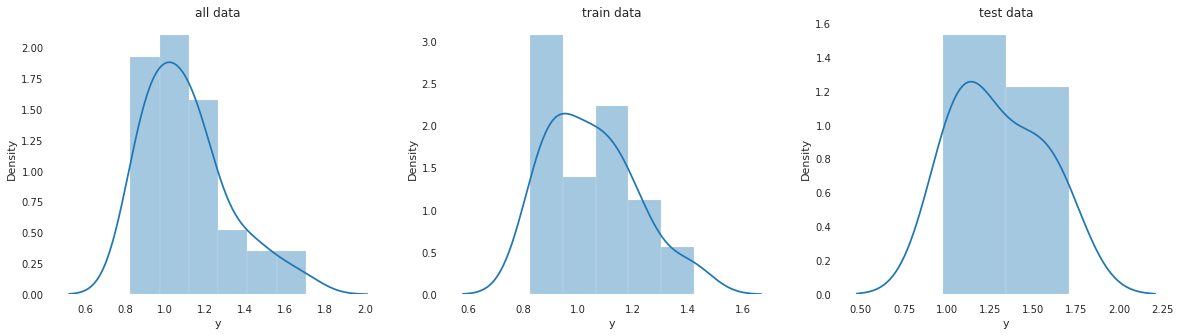

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['y'])
plt.title('all data')
plt.subplot(1,3,2)
sns.distplot(train['y'])
plt.title('train data')
plt.subplot(1,3,3)
sns.distplot(test['y'])
plt.title('test data')
plt.show()

In [36]:
y_test 

array([1.378 , 1.51  , 1.705 , 1.584 , 1.215 , 1.038 , 1.185 , 0.9775,
       1.075 ])

In [37]:
y_pred 

array([1.41970139, 1.37457781, 1.42869207, 1.60677305, 1.58592916,
       1.26417138, 1.22625151, 1.21510534, 1.4329647 ])

In [38]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']),columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']),columns=['Prediction'])

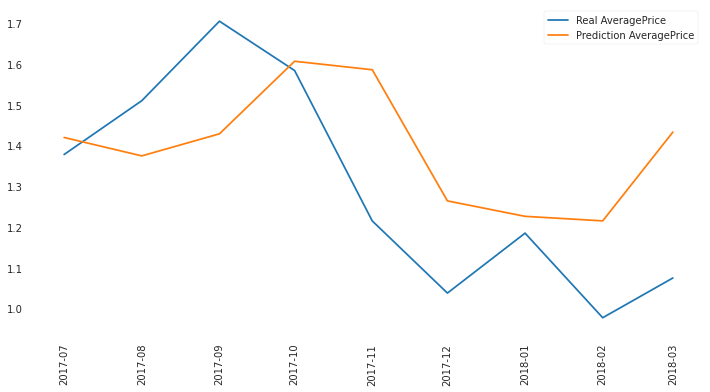

In [39]:
# Visulaize the result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='Real AveragePrice')
plt.plot(y_pred_value, label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: prediction và real value có sự chênh lệch chấp nhận được (~ 15% giá trị mean) nên mức dự đoán có thể chấp nhận được

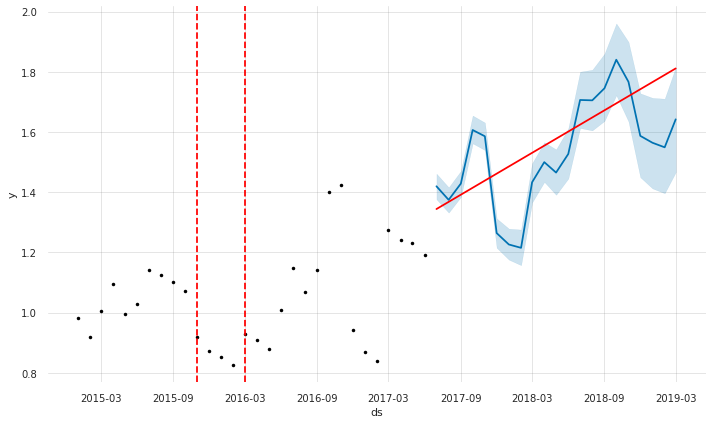

In [40]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),model,forecast)

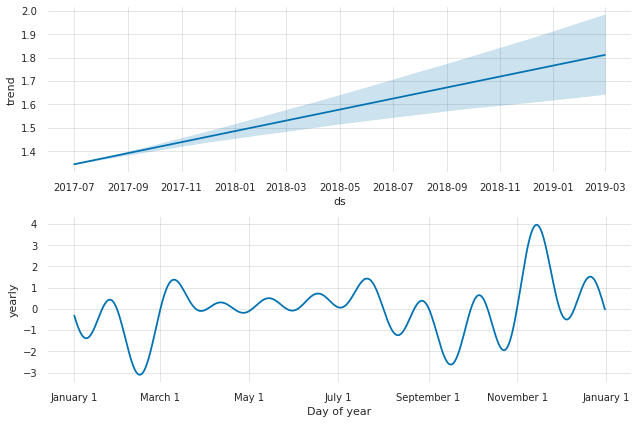

In [41]:
fig1 = model.plot_components(forecast)
fig1.show()

Nhận xét: xu hướng là tăng cho đến tháng 03/2019

#Dự đoán cho 12 tháng kế tiếp

In [42]:
forecast[['ds','yhat']].tail(12)

,ds,yhat
9,2018-04-01,1.499964
10,2018-05-01,1.465254
11,2018-06-01,1.527136
12,2018-07-01,1.706542
13,2018-08-01,1.705349
14,2018-09-01,1.745471
15,2018-10-01,1.840374
16,2018-11-01,1.766875
17,2018-12-01,1.587323
18,2019-01-01,1.564364


#Dự đoán cho 5 năm tiếp theo, chúng ta có thể mở rộng kinh doanh?

In [43]:
m = Prophet(yearly_seasonality=True, daily_seasonality=False,weekly_seasonality=False)
m.fit(df1) #fit df1 (dùng df1 để train) --> 39 tháng --> dự đoán tiếp 5  năm sau df1
future = m.make_future_dataframe(periods = 12*5,freq='M') # next 5 years

In [44]:
forecast = m.predict(future)

In [45]:
forecast.shape #39 tháng (train) + 60 tháng

(99, 16)

In [46]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          99 non-null     datetime64[ns]
 1   trend                       99 non-null     float64       
 2   yhat_lower                  99 non-null     float64       
 3   yhat_upper                  99 non-null     float64       
 4   trend_lower                 99 non-null     float64       
 5   trend_upper                 99 non-null     float64       
 6   additive_terms              99 non-null     float64       
 7   additive_terms_lower        99 non-null     float64       
 8   additive_terms_upper        99 non-null     float64       
 9   yearly                      99 non-null     float64       
 10  yearly_lower                99 non-null     float64       
 11  yearly_upper                99 non-null     float64       
 

In [47]:
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
87,2022-03-31,1.929791,1.766475,2.104698,1.920838,1.818334,2.028040
88,2022-04-30,1.808669,1.634524,1.971028,1.932449,1.826805,2.042311
89,2022-05-31,1.861899,1.688199,2.027827,1.944447,1.835082,2.058084
90,2022-06-30,2.084182,1.911516,2.254190,1.956058,1.843634,2.073961
91,2022-07-31,2.262959,2.089457,2.430292,1.968057,1.852730,2.089277
92,2022-08-31,2.236236,2.065473,2.410052,1.980055,1.862381,2.103935
93,2022-09-30,1.986521,1.807964,2.160183,1.991666,1.870217,2.119390
94,2022-10-31,1.683101,1.496637,1.872625,2.003664,1.879426,2.134617
95,2022-11-30,2.022829,1.839663,2.214128,2.015275,1.888317,2.149918
96,2022-12-31,2.044382,1.843066,2.230603,2.027274,1.895397,2.165647


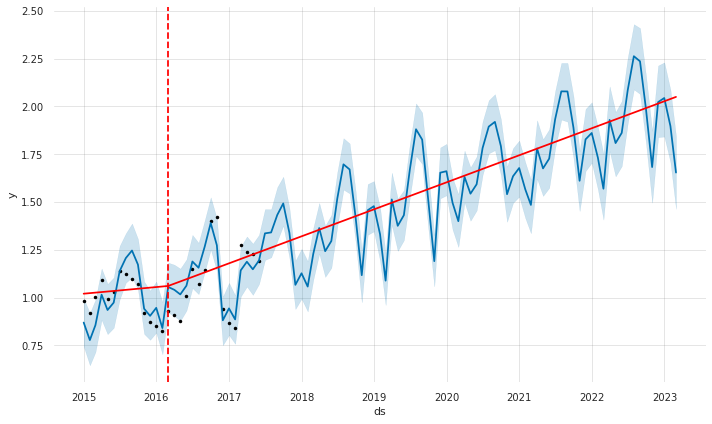

In [48]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),m,forecast)

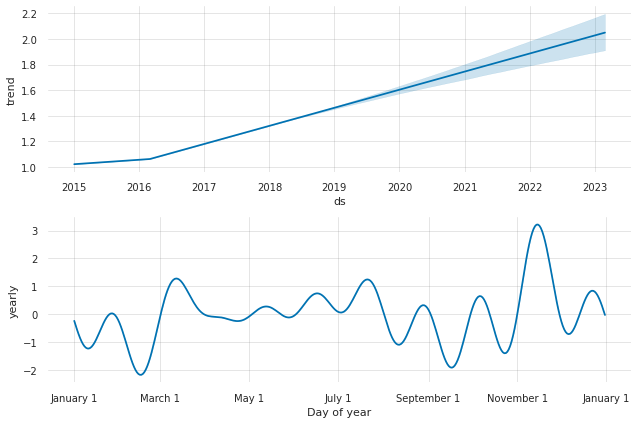

In [49]:
fig1 = m.plot_components(forecast)
fig1.show()

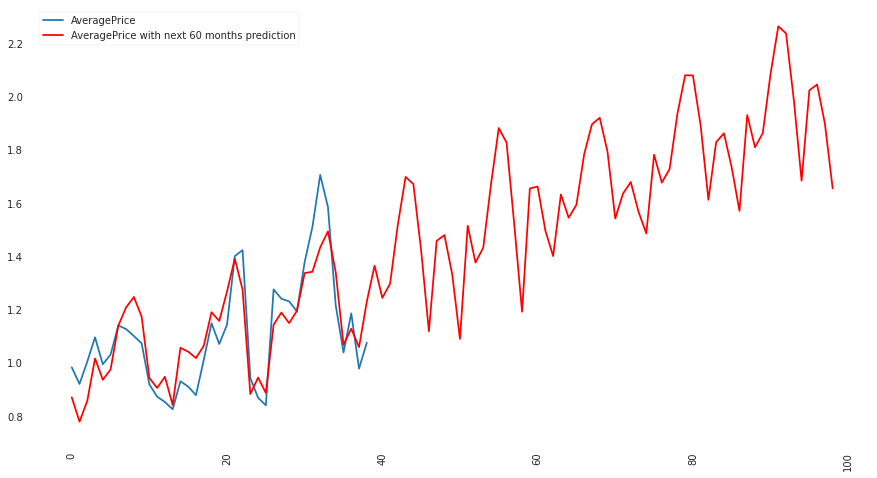

In [50]:
plt.figure(figsize=(15,8))
plt.plot(df1['y'],label='AveragePrice')
plt.plot(forecast['yhat'],label='AveragePrice with next 60 months prediction',color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Build model - ARIMA

In [51]:
from pmdarima import auto_arima 

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 11
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          169 non-null    datetime64[ns]
 1   AveragePrice  169 non-null    float64       
 2   type          169 non-null    object        
 3   region        169 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.6+ KB


In [53]:
df2 = df.resample('MS', on='Date').mean()

In [54]:
df2.head()

,AveragePrice
Date,
2015-01-01,0.9825
2015-02-01,0.9200
2015-03-01,1.0040
2015-04-01,1.0950
2015-05-01,0.9940


In [55]:
stepwise_model = auto_arima(df2, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=12,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=3.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-5.746, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-11.467, Time=1.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3.994, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-10.598, Time=1.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-8.598, Time=2.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-13.464, Time=0.64 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-12.583, Time=2.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-10.583, Time=2.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-11.476, Time=0.6

In [56]:
print(stepwise_model.aic())

-13.463640192679254


In [57]:
# Train & test: train  30 months, test 9 months
train = df2.iloc[:-9,:]
test = df2.iloc[-9:,:]

In [58]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [59]:
future_forecast = stepwise_model.predict(n_periods=len(test))
future_forecast

array([1.3243051 , 1.26046488, 1.31117209, 1.50561681, 1.48895616,
       1.10508781, 1.04253512, 1.01475637, 1.37674499])

In [60]:
future_forecast = pd.DataFrame(future_forecast,columns=['Prediction'],index=test.index)
future_forecast

,Prediction
Date,
2017-07-01,1.324305
2017-08-01,1.260465
2017-09-01,1.311172
2017-10-01,1.505617
2017-11-01,1.488956
2017-12-01,1.105088
2018-01-01,1.042535
2018-02-01,1.014756
2018-03-01,1.376745


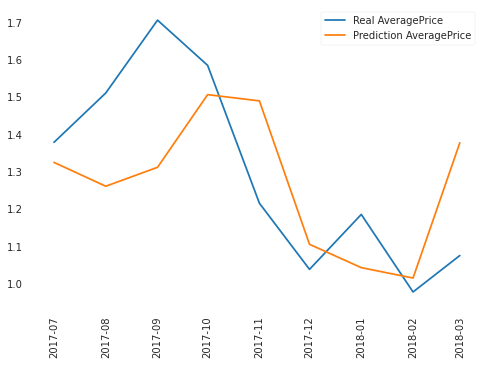

In [61]:
plt.plot(test,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

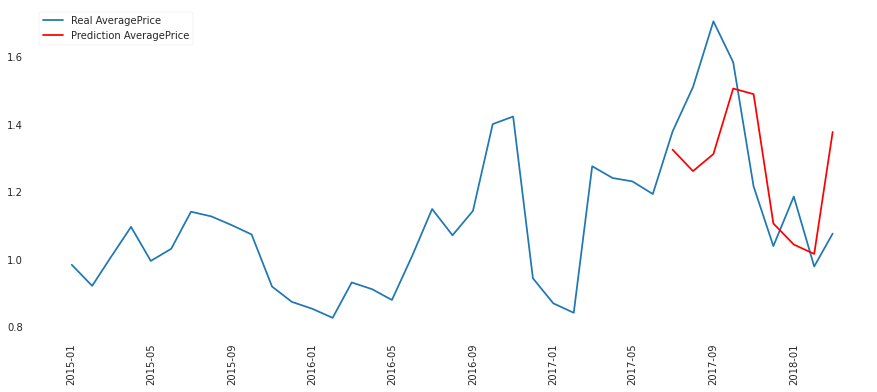

In [62]:
plt.figure(figsize=(15,6))
plt.plot(df2,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice',color='r')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: giá prediction và real có sự chênh lệch

#Evaluation

In [63]:
df2['AveragePrice'].mean()

1.1050769230769228

In [64]:
test['AveragePrice'].mean()

1.296388888888889

In [65]:
mae = mean_absolute_error(test, future_forecast[0:len(test)])
mae

0.17755014825315885

In [66]:
mse = mean_squared_error(test, future_forecast[0:len(test)])
mse

0.046520259736630605

- Mean test = 1.29, mae & mse ~ 13.6% of mean test
- Mean all data = 1.685, mae & mse ~ 16% of mean data
- Chênh lệch nhỏ => chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [67]:
future_forecast_12_month = stepwise_model.predict(n_periods=len(test)+12)
future_forecast_12_month

array([1.3243051 , 1.26046488, 1.31117209, 1.50561681, 1.48895616,
       1.10508781, 1.04253512, 1.01475637, 1.37674499, 1.34506369,
       1.33019626, 1.33019756, 1.46337326, 1.39640024, 1.45192903,
       1.66032451, 1.65232803, 1.24719087, 1.18199489, 1.15416718,
       1.53230932])

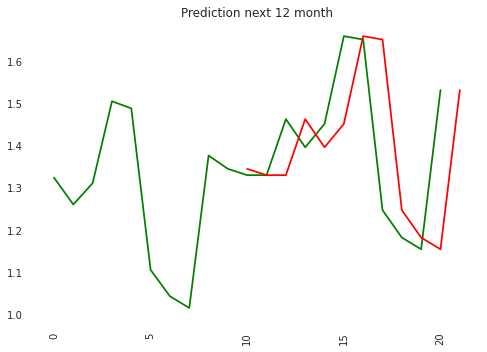

In [68]:
plt.plot(np.arange(21),future_forecast_12_month,color='g')
plt.plot(np.arange(10,22,1),future_forecast_12_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 month')
plt.show()

Dự báo cho 5 năm tiếp theo

In [69]:
future_forecast_60_month = stepwise_model.predict(n_periods=len(test)+60)
future_forecast_60_month

array([1.3243051 , 1.26046488, 1.31117209, 1.50561681, 1.48895616,
       1.10508781, 1.04253512, 1.01475637, 1.37674499, 1.34506369,
       1.33019626, 1.33019756, 1.46337326, 1.39640024, 1.45192903,
       1.66032451, 1.65232803, 1.24719087, 1.18199489, 1.15416718,
       1.53230932, 1.49989377, 1.48610325, 1.47780751, 1.61067997,
       1.54440007, 1.5988621 , 1.80417103, 1.79425762, 1.39382612,
       1.32921496, 1.30139808, 1.67596631, 1.64371321, 1.62968443,
       1.62322438, 1.75616393, 1.68973068, 1.74442873, 1.95042054,
       1.94093125, 1.53945864, 1.47471808, 1.44689881, 1.82225776,
       1.78996872, 1.77599265, 1.76912646, 1.90205116, 1.83565184,
       1.89029767, 2.0961384 , 2.08655528, 1.68531301, 1.62060108,
       1.59278234, 1.96796634, 1.93568525, 1.92169752, 1.91492119,
       2.04784918, 1.98144235, 2.03609973, 2.24197389, 2.23241152,
       1.83111829, 1.76640003, 1.73858117, 2.11380388])

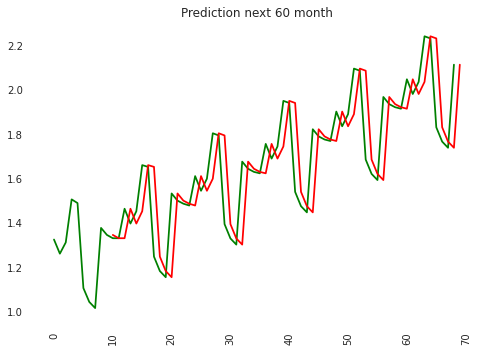

In [70]:
plt.plot(np.arange(69),future_forecast_60_month,color='g')
plt.plot(np.arange(10,70,1),future_forecast_60_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 60 month')
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Holt-Winters

In [71]:
model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12).fit()
pred = model.predict(start=test.index[0],end=test.index[-1])

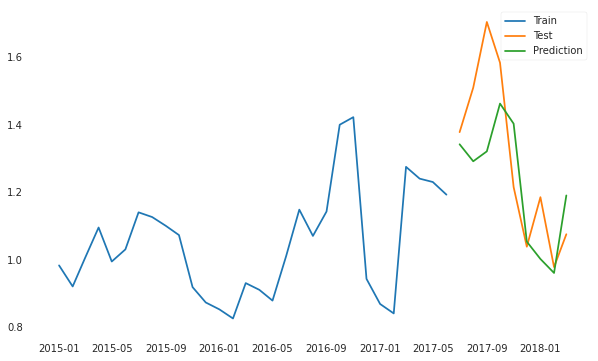

In [72]:
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.legend(loc='best')
plt.show()

#Evaluate

In [73]:
df2['AveragePrice'].mean()

1.1050769230769228

In [74]:
test['AveragePrice'].mean()

1.296388888888889

In [75]:
y_test = test['AveragePrice'].values
y_pred = pred.values
mae = mean_absolute_error(y_test, y_pred)
mae

0.1420951512760442

In [76]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.18073991603091058

- Mean test = 1.29, mae & mse ~ 10% of mean test
- Mean all data = 1.685, mae & mse ~ 12% of mean data
- Chênh lệch nhỏ => chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [77]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2019,3,1)
pred_next_12_month = model.predict(start=start,end=end)
pred_next_12_month

2018-04-01    1.202317
2018-05-01    1.153463
2018-06-01    1.193062
2018-07-01    1.341939
2018-08-01    1.291501
2018-09-01    1.320983
2018-10-01    1.462785
2018-11-01    1.403118
2018-12-01    1.053013
2019-01-01    1.001606
2019-02-01    0.960054
2019-03-01    1.190092
Freq: MS, dtype: float64

In [78]:
x = pd.Series(pred_next_12_month)
type(x)

pandas.core.series.Series

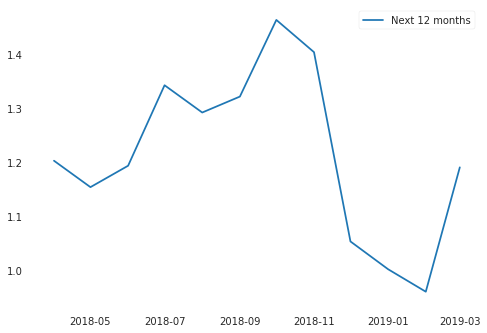

In [79]:
plt.plot(x.index,x,label='Next 12 months')
plt.legend(loc='best')

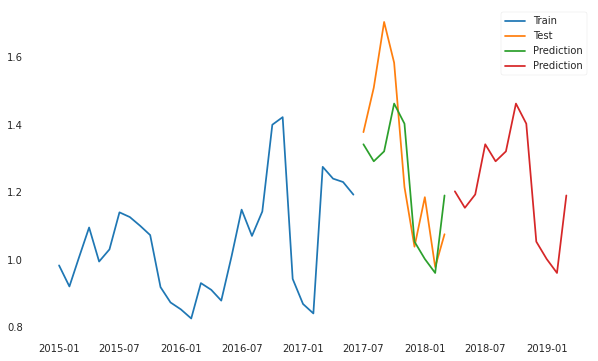

In [80]:
# Truc quan hoa 
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_12_month.index,pred_next_12_month,label='Prediction')
plt.legend(loc='best')
plt.show()

Dự báo cho 60 tháng tiếp theo 

In [81]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2023,3,1)
pred_next_60_month = model.predict(start=start,end=end)
pred_next_60_month[:10]

2018-04-01    1.202317
2018-05-01    1.153463
2018-06-01    1.193062
2018-07-01    1.341939
2018-08-01    1.291501
2018-09-01    1.320983
2018-10-01    1.462785
2018-11-01    1.403118
2018-12-01    1.053013
2019-01-01    1.001606
Freq: MS, dtype: float64

In [82]:
x = pd.Series(pred_next_60_month)
type(x)

pandas.core.series.Series

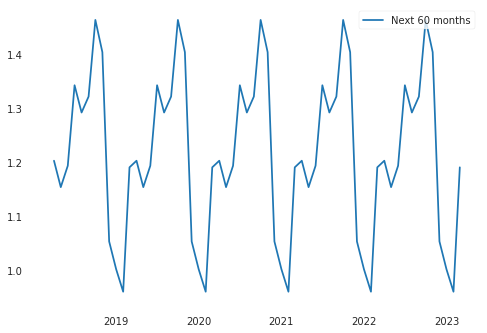

In [83]:
plt.plot(x.index,x,label='Next 60 months')
plt.legend(loc='best')

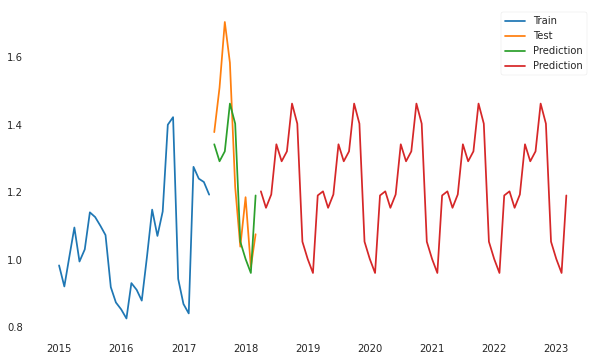

In [84]:
# Trực quan hóa
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_60_month.index,pred_next_60_month,label='Prediction')
plt.legend(loc='best')
plt.show()

<font color ='blue'> - Xu hướng tăng trưởng 5 năm tiếp theo biến động ổn định theo chu kỳ</font>

Tổng kết

###<font color='blue'>
- Qua phân tích các thuật toán Prophet, Arima, Holtwinters <br>
  <font color='blue'>
  + Prophet test data: mae & mse ~ 10%, all data: mae & mse ~ 10% => chênh lệch nhỏ chấp nhận được <br>
  + Arima test data: mae & mse ~ 14%, all data: mae & mse ~ 15% => chênh lệch lớn => không chọn thuật toán này <br>
  + Holtwinters test data: mae & mse ~ 10%, all data: mae & mse ~ 10% => chênh lệch nhỏ chấp nhận được</font>
- Dự báo xu hướng tăng trưởng từ 12 tháng đến 60 tháng tiếp theo của loại bơ conventional tại vùng california, cả 3 thuật toán trên có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này 
</font>